In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn import set_config
set_config(display='diagram')

In [2]:
filename = 'heart.csv'
df = pd.read_csv(filename)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.shape

(918, 12)

- Fuente de datos: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
- Breve descripción: Modelo de clasificación de ML para predecir si es que un paciente tendrá o no una enfermedad al corazón, utilizando características como edad, sexo, niveles de colesterol, tipo de dolor en el pecho, entre otras.
- ¿Cual es el objetivo?: Predecir si es que un paciente presentará una enfermedad al corazón o no.
- ¿Este es un problema de clasificación o regresión?: Clasificación.
- ¿Cuántas características hay?: 11 características.
- ¿Cuántas filas de datos hay?: 918 filas.
- ¿Qué retos, si es que hay alguno, prevén en la limpieza, exploración o modelización con este conjunto de datos?: A simple vista, se deben estandarizar los datos y además aplicar OHE.

In [4]:
#Verificación de filas duplicadas
df.duplicated().sum()

0

In [5]:
#Verificación de filas con valores NaN
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Diccionario del dataset:

- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [7]:
df['ExerciseAngina'].value_counts()

N    547
Y    371
Name: ExerciseAngina, dtype: int64

In [8]:
df['ExerciseAngina'].replace({'Y':1,'N':0}, inplace=True)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,0,0.0,Up,0


In [9]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.404139,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,0.490992,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000


Nuestra columna objetivo es: "HeartDisease". Al parecer, se presenta una incongruencia en los datos de RestingBP y Cholesterol, donde el valor mínimo es 0, lo cual es imposible.

In [10]:
df.loc[df['RestingBP']==0,:]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,0,1.5,Flat,1


La fila donde RestingBP == 0 es solo una, por lo que decido eliminarla. Para el caso del colesterol, decido rellenar las filas con el valor promedio, dependiendo de si HeartDisease es 1 o 0.

In [11]:
#Elimino la fila donde RestinBP == 0
df = df.drop(449)

In [12]:
promedio1 = df.loc[(df['Cholesterol'] != 0) & (df['HeartDisease'] == 1), 'Cholesterol'].mean()
promedio0 = df.loc[(df['Cholesterol'] != 0) & (df['HeartDisease'] == 0), 'Cholesterol'].mean()
print(promedio1)
print(promedio0)

251.06179775280899
238.76923076923077


In [13]:
df.loc[(df['Cholesterol'] == 0) & (df['HeartDisease'] == 1), 'Cholesterol'] = promedio1
df.loc[(df['Cholesterol'] == 0) & (df['HeartDisease'] == 0), 'Cholesterol'] = promedio0

In [14]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,245.565666,0.233370,136.789531,0.404580,0.886696,0.552890
std,9.437636,17.999749,53.409819,0.423206,25.467129,0.491078,1.066960,0.497466
min,28.000000,80.000000,85.000000,0.000000,60.000000,0.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,250.000000,0.000000,138.000000,0.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000


Podemos apreciar que Cholesterol ya no tiene como valor mínimo 0, al igual que RestingBP

In [15]:
df['HeartDisease'].value_counts()

1    507
0    410
Name: HeartDisease, dtype: int64

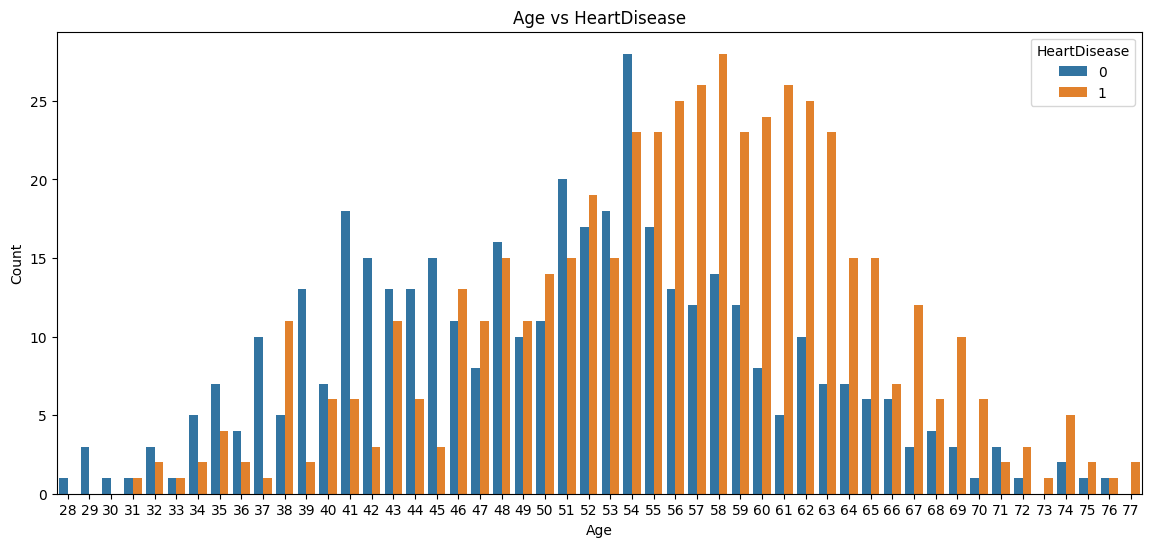

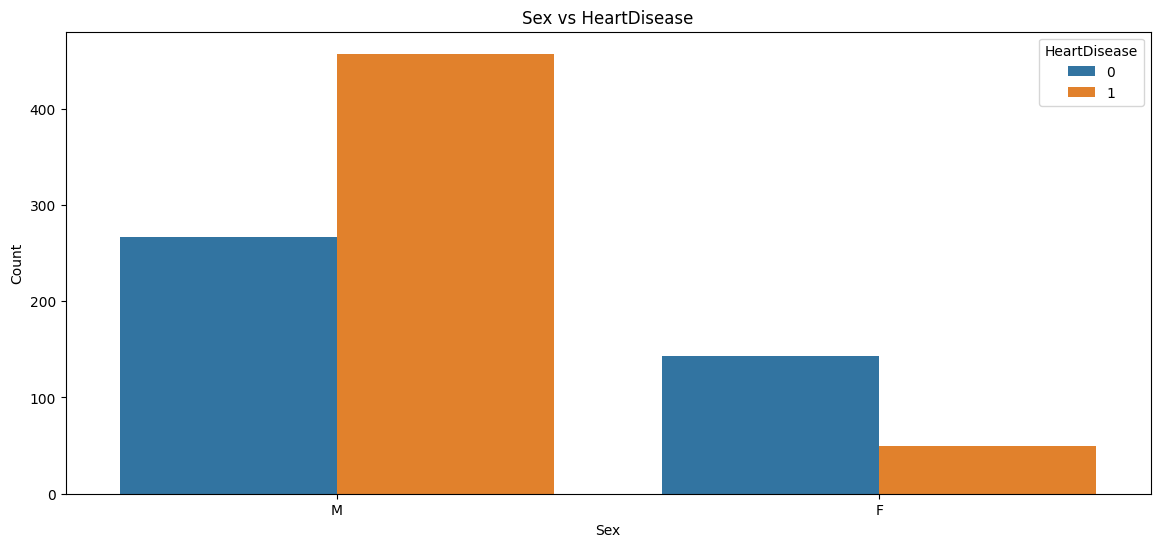

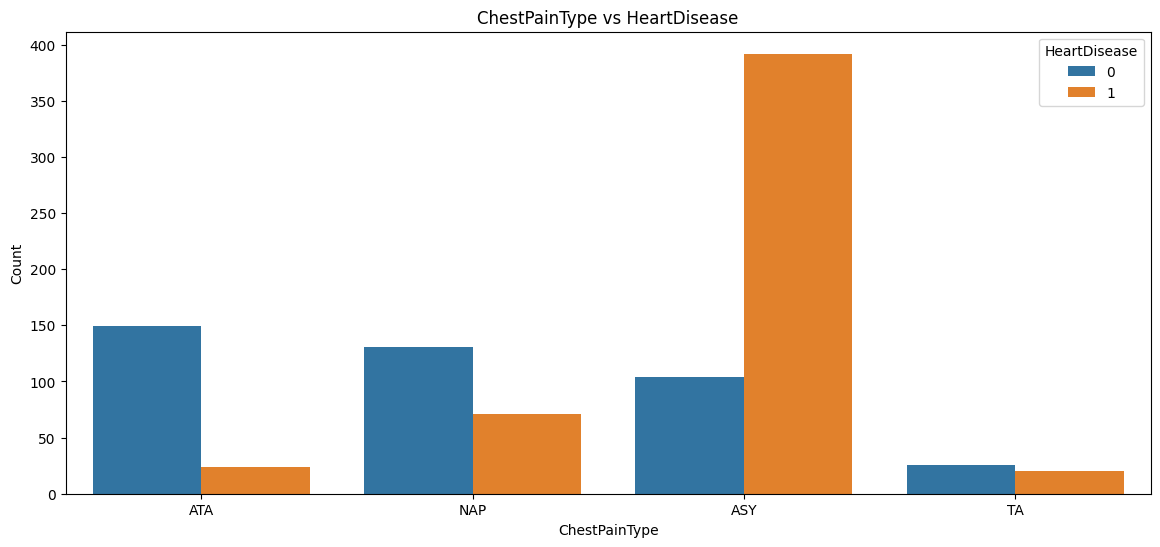

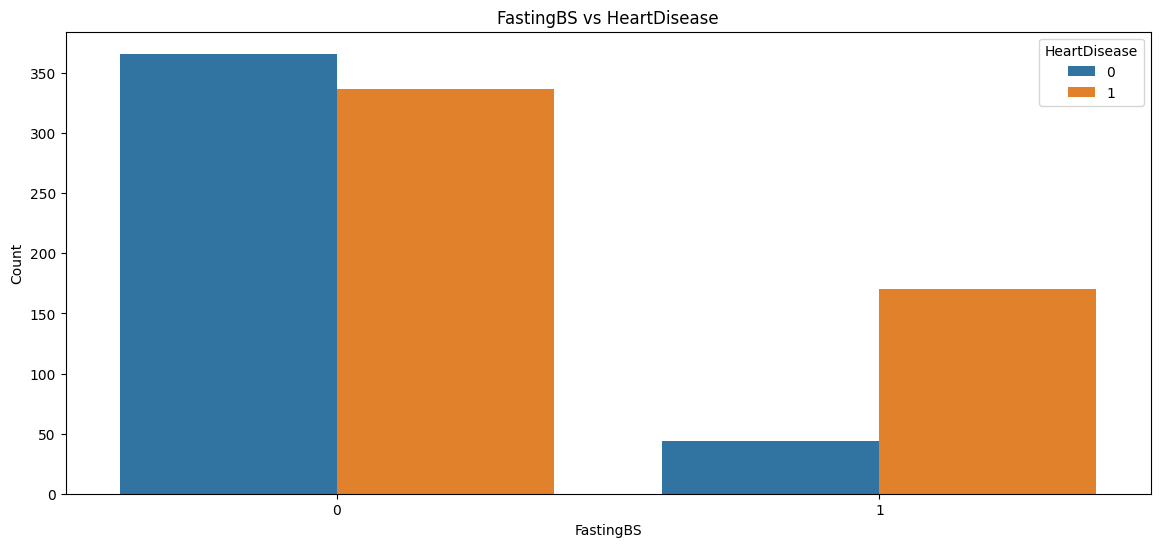

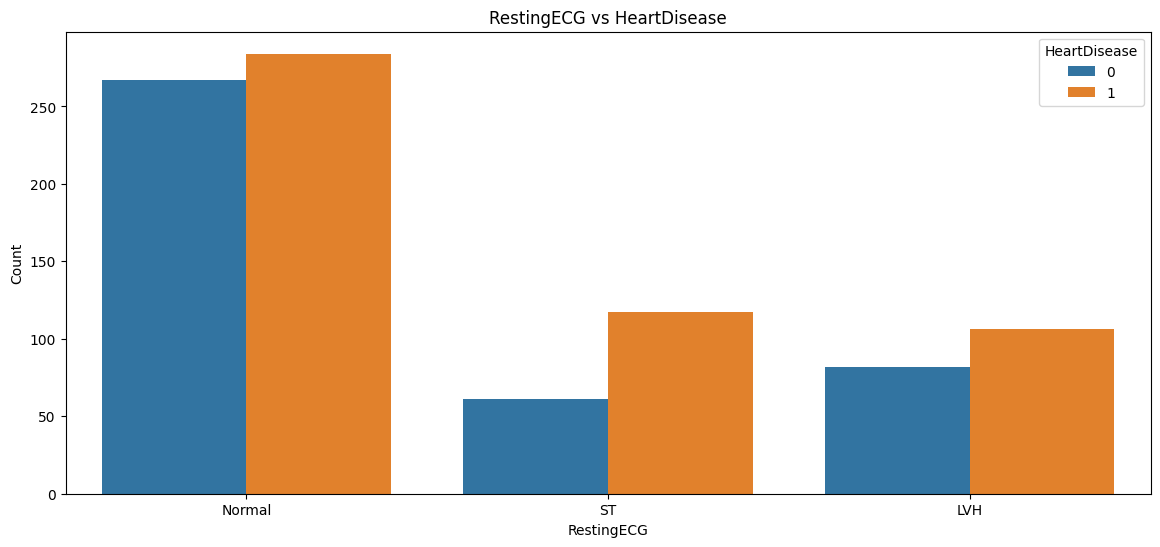

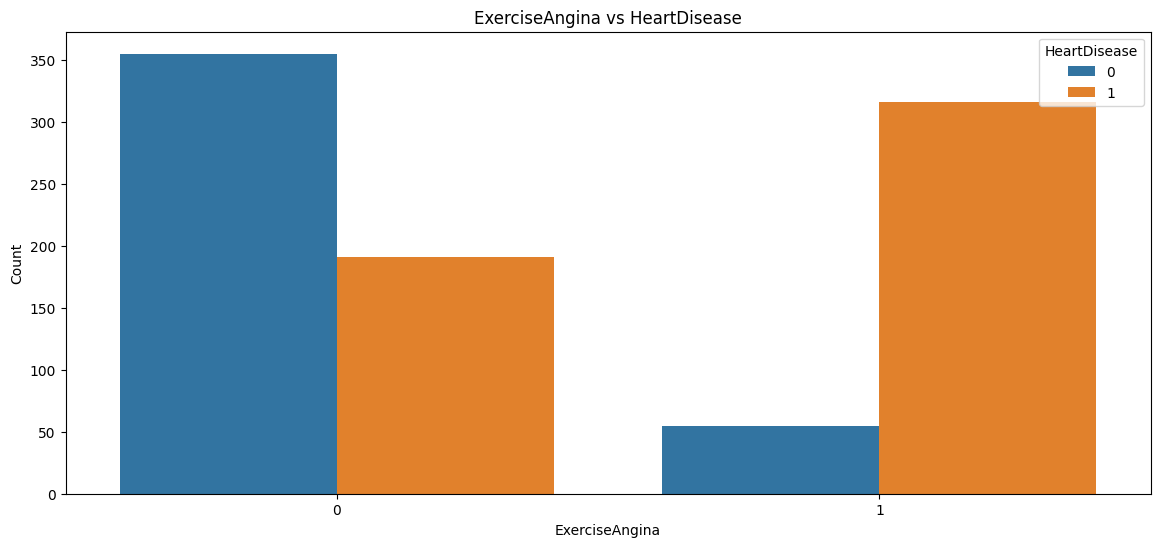

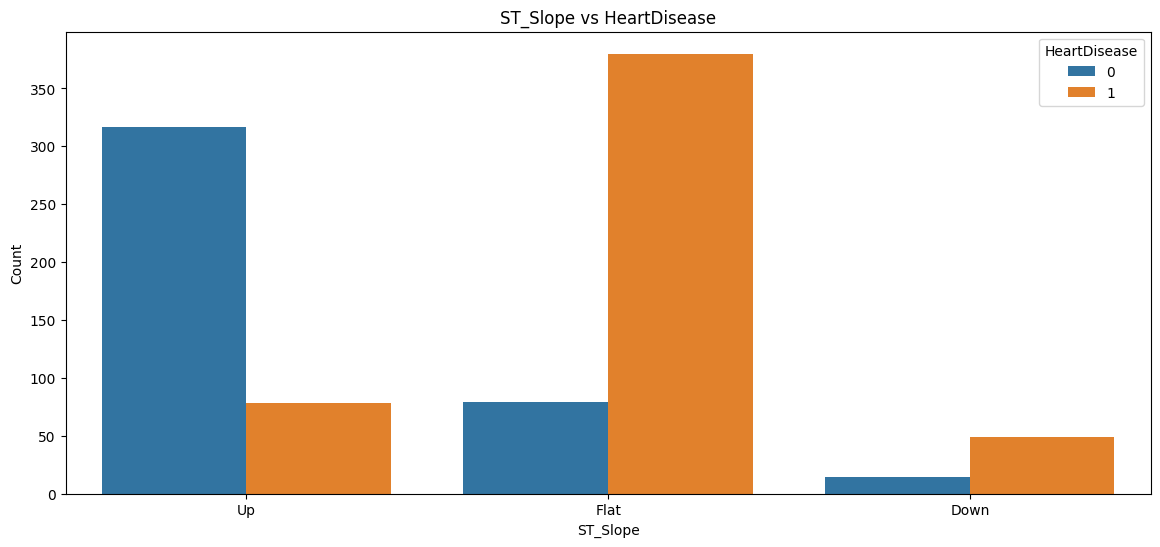

In [16]:
features = ['Age', 'Sex', 'ChestPainType', 'FastingBS',
            'RestingECG', 'ExerciseAngina', 'ST_Slope']

for feature in features:
    plt.figure(figsize=(14, 6))
    sns.countplot(x=feature, hue='HeartDisease', data=df)
    plt.title(f'{feature} vs HeartDisease')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='HeartDisease', loc='upper right')
    plt.show()

C:\Users\fabia\AppData\Local\Temp\ipykernel_15912\215740514.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


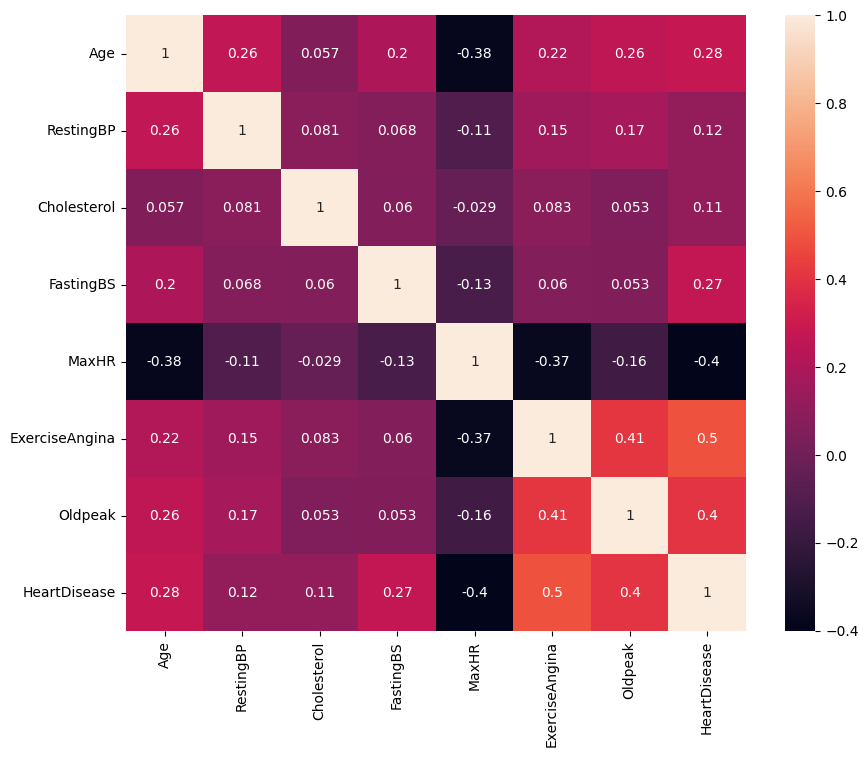

In [17]:
plt.figure(figsize=(10, 8))

sns.heatmap(df.corr(),annot=True)

plt.show()

In [18]:
X = df.drop(columns='HeartDisease')
y = df['HeartDisease']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [19]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [20]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

In [21]:
num_tuple = (scaler,num_selector)
cat_tuple = (ohe,cat_selector)

In [22]:
col_transformer = make_column_transformer(num_tuple,cat_tuple,remainder='passthrough')

In [23]:
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002301819DC60>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000230181B2AA0>)])

In [24]:
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

# Regresión Logística:

In [25]:
reg = LogisticRegression()

In [26]:
reg.fit(X_train_processed,y_train)

LogisticRegression()

In [27]:
y_pred = reg.predict(X_test_processed)

In [28]:
#Métricas para la regresión logística
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy Score: 0.8782608695652174
Precision: 0.9242424242424242
Recall: 0.8714285714285714
F1 Score: 0.8970588235294117


In [29]:
y_train

155    1
362    1
869    0
101    0
199    0
      ..
106    0
270    0
861    1
435    0
102    1
Name: HeartDisease, Length: 687, dtype: int64

# KNN:

In [30]:
df_train_transformed = pd.DataFrame(X_train_processed)
df_train_transformed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.247343,1.274860,1.809144,1.844952,0.550076,1.194806,1.917754,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.247343,1.274860,0.079871,-0.542020,-1.478661,-0.836956,-0.830849,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.566351,0.990832,-0.662925,1.844952,0.828530,-0.836956,0.635073,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.284337,-0.145280,-1.290451,-0.542020,-1.438882,-0.836956,-0.830849,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.353679,-0.145280,1.162603,-0.542020,-1.518441,-0.836956,0.085352,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,-0.603345,-0.713336,0.135743,-0.542020,-1.041091,-0.836956,-0.830849,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
683,-0.922353,-0.713336,-0.415718,-0.542020,0.152284,-0.836956,-0.830849,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
684,1.204367,-1.281392,0.021648,-0.542020,0.868309,-0.836956,-0.281128,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
685,0.672687,1.104443,-0.153884,-0.542020,-0.722857,1.194806,-0.830849,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [31]:
df_train_transformed.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,687.00,687.00,687.00,687.00,687.00,687.00,687.00,687.00,687.00,687.00,687.00,687.00,687.00,687.00,687.00,687.00,687.00,687.0,687.00
mean,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.78,0.53,0.19,0.23,0.05,0.21,0.60,0.19,0.07,0.5,0.44
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.41,0.41,0.50,0.39,0.42,0.22,0.41,0.49,0.40,0.25,0.5,0.50
min,-2.62,-2.19,-3.08,-0.54,-2.91,-0.84,-3.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
25%,-0.71,-0.71,-0.62,-0.54,-0.68,-0.84,-0.83,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
50%,0.03,-0.15,0.08,-0.54,0.07,-0.84,-0.37,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.0,0.00
75%,0.73,0.42,0.43,-0.54,0.75,1.19,0.54,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.0,1.00
max,2.48,3.83,6.77,1.84,2.14,1.19,4.85,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00


Text(0, 0.5, 'inertia')

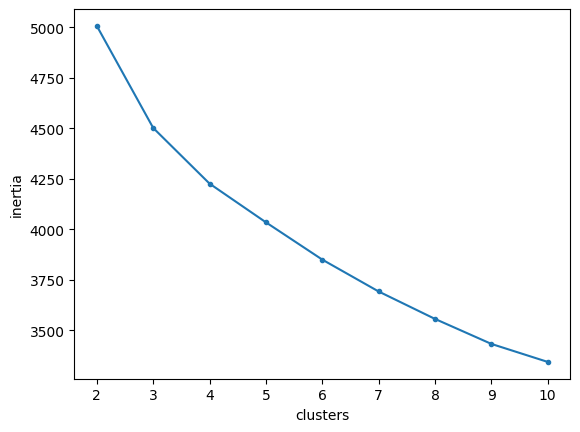

In [32]:
#Método del codo
inertias = []
#Loop through k values between 2 and 10 and store the inertias in the list.
for k in range(2,11):  
    kmeans = KMeans(n_clusters=k)  
    kmeans.fit(df_train_transformed)  
    inertias.append(kmeans.inertia_)
#Visualize scores
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('clusters')
plt.ylabel('inertia')

Podemos apreciar que en el N° de clusters = 3, se puede apreciar un pequeño cambio en la curva.

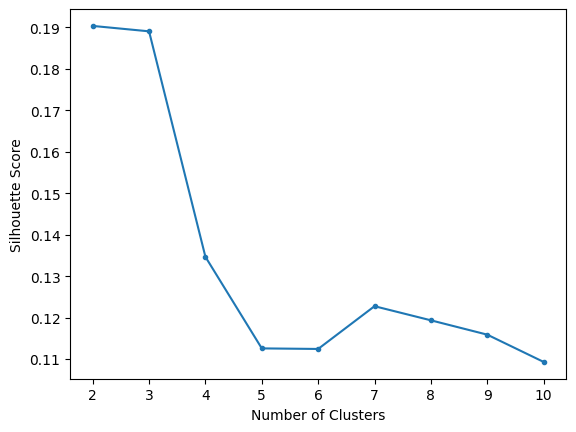

In [33]:
#Silhouette Score
# Save silhouette scores for various cluster numbers in list
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(df_train_transformed)
  silhouette_scores.append(silhouette_score(df_train_transformed, kmeans.labels_))
# Visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

Según el Silhouette Score, 2 o 3 sería un buen número de vecinos.

In [34]:
#Modelando con n_neighbors =2
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train_processed, y_train)

KNeighborsClassifier(n_neighbors=2)

In [35]:
y_pred = knn.predict(X_test_processed)

In [36]:
#Métricas para KNN con 2 neighbors
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy Score: 0.7739130434782608
Precision: 0.9074074074074074
Recall: 0.7
F1 Score: 0.7903225806451613


In [37]:
#Modelando con n_neighbors = 3
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_processed, y_train)

KNeighborsClassifier(n_neighbors=3)

In [38]:
y_pred = knn.predict(X_test_processed)

In [39]:
#Métricas para KNN con 3 neighbors
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy Score: 0.8521739130434782
Precision: 0.8955223880597015
Recall: 0.8571428571428571
F1 Score: 0.8759124087591241


# Gradient Boosting:

In [40]:
gb = GradientBoostingClassifier()
gb.fit(X_train_processed, y_train)

GradientBoostingClassifier()

In [41]:
y_pred = gb.predict(X_test_processed)

In [42]:
#Métricas para Gradient Boosting
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy Score: 0.8956521739130435
Precision: 0.9084507042253521
Recall: 0.9214285714285714
F1 Score: 0.9148936170212766


# Light GBM:

In [43]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_processed, y_train)

LGBMClassifier()

In [44]:
y_pred = lgbm.predict(X_test_processed)

In [45]:
#Métricas para Light GBM
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy Score: 0.8956521739130435
Precision: 0.9328358208955224
Recall: 0.8928571428571429
F1 Score: 0.9124087591240876


# XGBoost:

In [46]:
xgb = XGBClassifier()
xgb.fit(X_train_processed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [47]:
y_pred = xgb.predict(X_test_processed)

In [48]:
#Métricas para la XGBoost
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy Score: 0.8913043478260869
Precision: 0.9259259259259259
Recall: 0.8928571428571429
F1 Score: 0.9090909090909091


Acorde a los puntajes de accuracy, precision, recall y F1; la mejor opción para el modelo sería utilizar GradientBoosting.

In [49]:
gb = GradientBoostingClassifier()
gb.fit(X_train_processed, y_train)

y_pred = gb.predict(X_test_processed)

#Métricas para Gradient Boosting
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy Score: 0.8956521739130435
Precision: 0.9084507042253521
Recall: 0.9214285714285714
F1 Score: 0.9148936170212766


In [50]:
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [51]:
max_depth_values = [3, 4, 5, 6, 7, 8, 9, 10]

mean_scores = []
for max_depth in max_depth_values:
    gb_classifier = GradientBoostingClassifier(max_depth=max_depth)
    scores = cross_val_score(gb, X_train_processed, y_train, cv=5)
    mean_scores.append(scores.mean())

optimal_index = np.argmax(mean_scores)
optimal_max_depth = max_depth_values[optimal_index]

gb_classifier = GradientBoostingClassifier(max_depth=optimal_max_depth)
gb_classifier.fit(X_train_processed, y_train)

y_pred = gb_classifier.predict(X_test_processed)

#Métricas para Gradient Boosting
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy Score: 0.8782608695652174
Precision: 0.8943661971830986
Recall: 0.9071428571428571
F1 Score: 0.900709219858156


In [52]:
optimal_max_depth

5

Al realizar la prueba, comprobamos que el valor de max depth es igual a 3.

In [54]:
cm = confusion_matrix(y_test, y_pred)

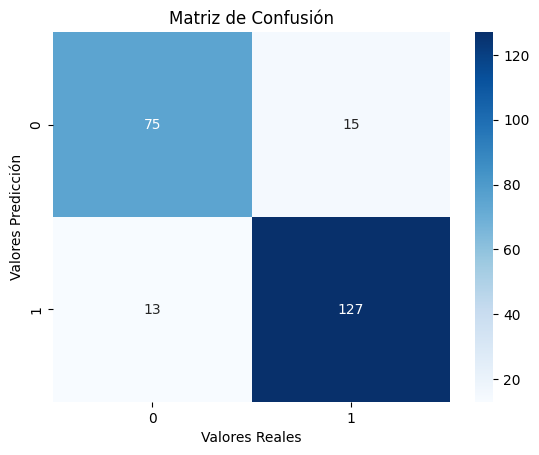

In [59]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Ajusta los ejes para que se muestren correctamente
plt.title("Matriz de Confusión")
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predicción")

# Muestra el mapa de calor
plt.show()